<a href="https://colab.research.google.com/github/18108851659-yzh/NLP/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.4.1
Hub version: 0.11.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [4]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/aclImdb.zip >train2.log

In [6]:
import os
imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
 dir_name = os.path.join(train_dir, label_type)
 for fname in os.listdir(dir_name):
   if fname[-4:] == '.txt':
    f = open(os.path.join(dir_name, fname))
    texts.append(f.read())
    f.close()
    if label_type == 'neg':
      labels.append(0)
    else:
      labels.append(1)

In [7]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/upfile/glove.6B.zip -d /content/drive/MyDrive/Colab\ Notebooks/upfile/ >train3.log

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 100 
training_samples = 200 
validation_samples = 10000 
max_words = 10000 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0]) 
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples] 
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [10]:
glove_dir = '/content/drive/MyDrive/Colab Notebooks/upfile/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
 if i < max_words:
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
   embedding_matrix[i] = embedding_vector

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [17]:
model.compile(optimizer='rmsprop',
 loss='binary_crossentropy',
 metrics=['acc'])
history = model.fit(x_train, y_train,
 epochs=10,
 batch_size=32,
 validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 3s 134ms/step - loss: 2.2017 - acc: 0.4696 - val_loss: 1.0756 - val_acc: 0.5015
Epoch 2/10
7/7 [==============================] - 1s 107ms/step - loss: 0.7408 - acc: 0.6134 - val_loss: 1.0970 - val_acc: 0.5008
Epoch 3/10
7/7 [==============================] - 1s 110ms/step - loss: 0.5232 - acc: 0.6721 - val_loss: 1.2301 - val_acc: 0.5019
Epoch 4/10
7/7 [==============================] - 1s 107ms/step - loss: 0.3117 - acc: 0.8604 - val_loss: 0.7279 - val_acc: 0.5549
Epoch 5/10
7/7 [==============================] - 1s 107ms/step - loss: 0.1129 - acc: 0.9968 - val_loss: 2.4479 - val_acc: 0.4988
Epoch 6/10
7/7 [==============================] - 1s 107ms/step - loss: 0.6316 - acc: 0.7105 - val_loss: 0.8657 - val_acc: 0.5394
Epoch 7/10
7/7 [==============================] - 1s 106ms/step - loss: 0.0569 - acc: 1.0000 - val_loss: 0.7584 - val_acc: 0.5593
Epoch 8/10
7/7 [==============================] - 1s 131ms/step - loss: 0.0483 - acc: 1.00

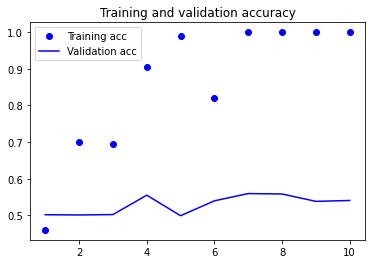

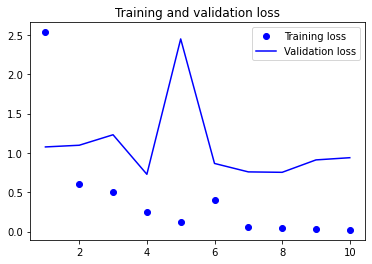

In [19]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
 loss='binary_crossentropy',
 metrics=['acc'])
history = model.fit(x_train, y_train,
 epochs=10,
 batch_size=32,
 validation_data=(x_val, y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 137ms/step - loss: 0.6942 - acc: 0.4662 - val_loss: 0.6930 - val_acc: 0.5095
Epoch 2/10
7/7 [==============================] - 1s 117ms/step - loss: 0.5178 - acc: 0.9901 - val_loss: 0.6974 

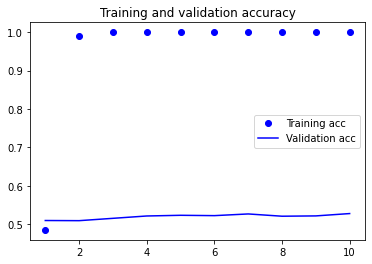

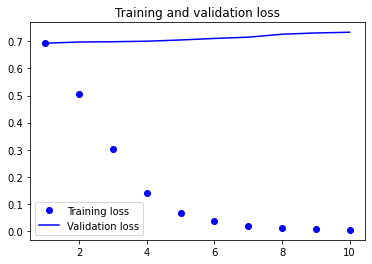

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
 dir_name = os.path.join(test_dir, label_type)
 for fname in sorted(os.listdir(dir_name)):
  if fname[-4:] == '.txt':
    f = open(os.path.join(dir_name, fname))
    texts.append(f.read())
    f.close()
    if label_type == 'neg':
      labels.append(0)
    else:
      labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [24]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.9434 - acc: 0.5404


[0.943425714969635, 0.540440022945404]

In [25]:
!ls -l;mv /content/aclImdb /content/drive/MyDrive/Colab\ Notebooks/

total 10020
drwxr-xr-x 4 root root    4096 Nov 18  2017 aclImdb
drwx------ 4 root root    4096 Feb  5 03:02 drive
drwxrwxr-x 3 root root    4096 Nov 18  2017 __MACOSX
-rw-r--r-- 1 root root 5296440 Feb  5 03:32 pre_trained_glove_model.h5
drwxr-xr-x 1 root root    4096 Feb  1 17:27 sample_data
-rw-r--r-- 1 root root 4932060 Feb  5 03:09 train2.log
-rw-r--r-- 1 root root     384 Feb  5 03:17 train3.log
-rw-r--r-- 1 root root      61 Feb  5 03:04 train.log
